# Task

#### Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

## The Dataset

#### We could choose between Animals 10 and CIFAR-10; we chose the latter to focus on training our models.

#### - 60,000 32x32 color images in 10 classes
#### - 6,000 images per class.

## Imports

In [8]:
import os
import pickle
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation, RandomFlip, RandomTranslation, Lambda

## Setting the random seed

#### This will guarantee near-reproducible results.

#### TensorFlow is not bit-exact deterministic by default, so some tiny numerical differences can occur (~0.1 %-0.3 %). 

#### This can escalate exponentially, but the cost for determinism would be slowing down our training using the following import:

#### `from tensorflow.config.experimental import enable_op_determinism`

#### We decided not to use the import.

In [15]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load CIFAR-10 dataset

In [16]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Data Exploration

#### Let's take a look at the shapes of our training and testing data. 

#### The second, third, and fourth columns of X will be our input format for the NN.

In [17]:
print('X_train: ' ,X_train.shape)
print('X_test: ' ,X_test.shape)
print('y_train: ' ,y_train.shape)
print('y_test: ' ,y_test.shape)

X_train:  (50000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
y_train:  (50000, 1)
y_test:  (10000, 1)


#### Also, it is good to define our classes as they are presented on the dataset homepage.

#### As we can see below, they are all perfectly balanced.

In [18]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(class_names[u], c)

airplane 5000
automobile 5000
bird 5000
cat 5000
deer 5000
dog 5000
frog 5000
horse 5000
ship 5000
truck 5000


### Check the min max pixel value

#### Just as a sanity check, let's see the min and max of the values, they should be 0 and 255

In [20]:
print("Min pixel value:", X_train.min())
print("Max pixel value:", X_train.max())

Min pixel value: 0
Max pixel value: 255


## Data Preprocessing 

#### Let's make our target y categorical and normalize our X by dividing its value by 255.

### OHE y to categorical 

In [21]:
num_classes = 10
y_train_ohe = to_categorical(y_train, num_classes)
y_test_ohe  = to_categorical(y_test,  num_classes)

In [22]:
print('y_train_ohe: ' ,y_train_ohe.shape)
print('y_test_ohe: ' ,y_test_ohe.shape)

y_train_ohe:  (50000, 10)
y_test_ohe:  (10000, 10)


### Normalize the training and test

In [23]:
X_train = X_train.astype('float32')/255.0

In [24]:
X_test = X_test.astype('float32')/255.0

#### As a sanity check let's see the mean and standard deviation.

In [25]:
mean_train = X_train.mean(axis=(0,1,2))
std_train  = X_train.std(axis=(0,1,2))

mean_test = X_test.mean(axis=(0,1,2))
std_test  = X_test.std(axis=(0,1,2))


print("Mean:", mean_train)
print("Std:", std_train)
print("Mean:", mean_test)
print("Std:", std_test)

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]
Mean: [0.49421427 0.4851322  0.45040992]
Std: [0.24665268 0.24289216 0.2615922 ]


### Add early stopping

#### We decided to add early stopping after observing better epochs before the end.

In [26]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

## Challenger Model 1: 

#### We added One more Conv. Layer with 32 N, added the Dropout of 0.25 after the convolution, and 0.5 for the Dense Layer.

#### We got 68 % as Test accuracy and 0.91 as test loss.

In [83]:
challenger = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [85]:
challenger_history = challenger.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.2978 - loss: 1.9229 - val_accuracy: 0.5228 - val_loss: 1.3554
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4749 - loss: 1.4490 - val_accuracy: 0.5716 - val_loss: 1.2088
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5288 - loss: 1.3086 - val_accuracy: 0.6126 - val_loss: 1.1211
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5634 - loss: 1.2190 - val_accuracy: 0.6360 - val_loss: 1.0480
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5924 - loss: 1.1456 - val_accuracy: 0.6562 - val_loss: 0.9991
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6106 - loss: 1.0985 - val_accuracy: 0.6590 - val_loss: 0.9767
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6192 - loss: 1.0583 - val_accuracy: 0.6606 - val_loss: 0.9721
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6389 - loss: 1.0148 - 

#### We got 68 % as Test accuracy and 0.91 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6923 - loss: 0.8869
Test accuracy: 0.6866999864578247
Test loss: 0.9126209020614624


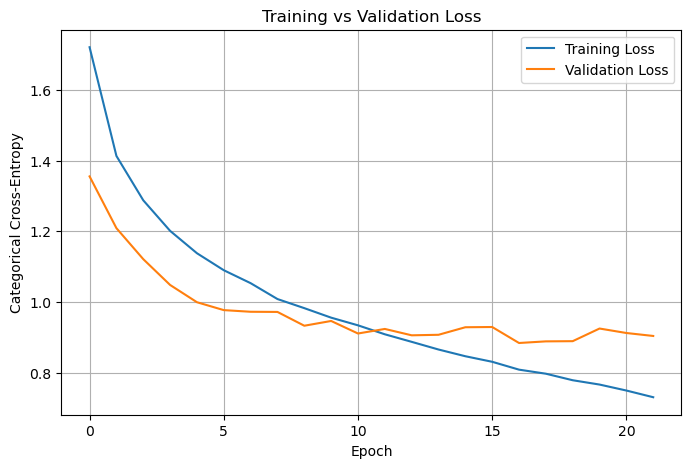

In [88]:
test_loss, test_acc = challenger.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger_history.history['loss'], label='Training Loss')
plt.plot(challenger_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
y_pred_proba = challenger.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


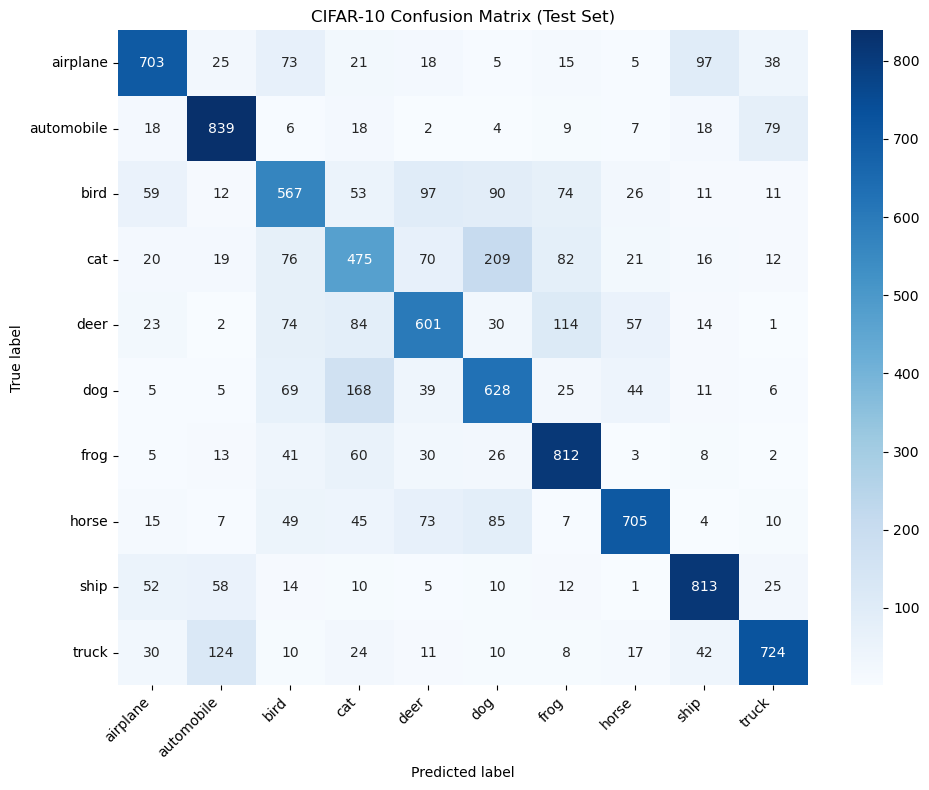

In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
# with open('challenger1.pkl', 'wb') as file:
#     pickle.dump(challenger1, file)